In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import scipy.spatial.distance as dista
from sklearn.preprocessing import normalize
from sklearn import metrics
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from copy import deepcopy
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [2]:
PATH="C:/Users/harsh/Desktop/Sem-2/ML/CS5402-master/homework5/"
data = pd.read_csv(PATH + 'football.csv')
print(data.shape)
data.head()

(10, 3)


,Team,wins_16,wins_17
0,X1,3,5
1,X2,3,4
2,X3,2,8
3,X4,2,3
4,X5,6,2


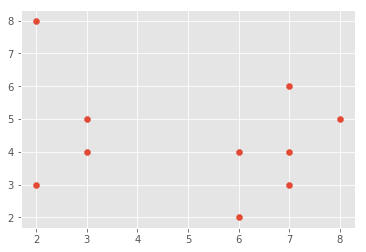

In [3]:
f1 = data['wins_16'].to_numpy()
f2 = data['wins_17'].to_numpy()
X = np.column_stack((f1, f2))
plt.scatter(f1, f2)

In [4]:
k=2
Center_1 = np.array([4,5])
Center_2 = np.array([6,4])
C = np.column_stack([Center_1, Center_2])
colors = ['r', 'g', 'b', 'y', 'c', 'm']


In [5]:
def distance(a, b, ax=1, metric='e'):
    switcher={
        'm':np.sum(np.abs(a-b), axis=ax),
        'e':np.sum((a-b)**2, axis=ax),
        'c':cosine_sim(a,b,metric),
        'j':(1-np.sum(np.minimum(a,b),axis=ax)/np.sum(np.maximum(a,b),axis=ax))
    }
    return switcher.get(metric)

def kmeans(X, Centroid=C, k=2, kmeans_metric='m',criteria=0):
    
    max_iter = 100
    np.random.seed(89)
    
    if kmeans_metric=='m':
        kmeans_cri = 'Manhattan'
    elif kmeans_metric=='e':
        kmeans_cri = 'Euclidean'
    elif kmeans_metric=='j':
        kmeans_cri = "Jacard"
    elif kmeans_metric == 'c':
        kmeans_cri = 'Cosine'
    
    if criteria==0:
        cri='Centroids'
    elif criteria ==1:
        cri='sse'
    elif criteria ==2:
        cri = 'Max Iteration'
    
    if Centroid is None:
        Centroid = X[np.random.choice(len(X), size=k, replace=False)]
    
    # Temprarily store Centroid values
    old_C = np.ones(Centroid.shape)
    
    # Cluster Lables
    clusters = np.zeros(len(X))
    
    # Error func. - Distance between new centroids and old centroids  
    err = np.array(distance(Centroid, old_C, None, metric=kmeans_metric))

    count = 1
    sse_prev = 0.1
    sse_curr = 0
    print(" ")
    print('Criteria is ',cri)
    print('Distance metric is ',kmeans_cri)
    
    while (err.any() != 0 and count<=max_iter):
        
        # Assigning each value to its closest cluster
        for i in range(len(X)):
            dist = distance(X[i], Centroid,1,kmeans_metric)
            clusters[i] = np.argmin([dist])
                         
        # Storing the old centroid values
        old_C = deepcopy(Centroid)
        sse_curr = sse(X, clusters, Centroid)

        print('Iteration: ' + str(count) + ' Current SSE: ' + str(sse_curr) + ' Previous SSE: ' + str(sse_prev))
        
        # Finding the new centroids by taking the average value
        for i in range(k):
            points = [X[j] for j in range(len(X)) if clusters[j] == i]
            Centroid[i] = np.mean(points, axis=0) 
        
        err_old = deepcopy(err)
        err = distance(Centroid, old_C, None,kmeans_metric)
        
        
        if np.sum(err_old) == np.sum(err) and criteria == 0 :
            break
        elif sse_prev<sse_curr and criteria==1:
            break
        elif count>0 and criteria==2:
            break
            
        count= count+1
        sse_prev = sse_curr
    return clusters, count


def visualise_football(C_x, C_y,metric):
    fig, ax = plt.subplots()
    
    C = np.column_stack((C_x,C_y))
    # Plotting along with the Centroids
    plt.scatter(f1, f2, c='#050505')
    plt.scatter(C_x, C_y, marker='*', s=200, c='y')
    clust, count = kmeans(X, Centroid=C, k=2,kmeans_metric=metric, )
    print('Number of count: '+str(count))
    for i in range(k):
        points = np.array([X[j] for j in range(len(X)) if clust[j] == i])
        ax.scatter(points[:, 0], points[:, 1], c=colors[i])
        
    ax.scatter(C[:, 0], C[:, 1], marker='*', s=200, c='#050505')
    ax.legend(["default","old centroids","clust 1","clust 2","new centroids"])
    


def sse(X, clusters, C, metric='e'):
    err = 0
    for i, centroid in enumerate(C):
        err += np.sum(distance(X[np.where(clusters==i)], centroid,ax=1,metric='e'))
    
    return err

def predict(clusters, y, k=3):
    indexes = []
    for i in range(k):
        indexes.append(np.where(clusters == i))
    for cluster in indexes:
        mode = int(stats.mode(y[cluster])[0])
        clusters[cluster] = mode
        
    return clusters

def visualise_iris(kmeans_metric,criteria):
    print("   ")
    print("   ")

    if kmeans_metric=='m':
        kmeans_cri = 'Manhattan'
    elif kmeans_metric=='e':
        kmeans_cri = 'Euclidean'
    elif kmeans_metric=='j':
        kmeans_cri = "Jacard"
    elif kmeans_metric == 'c':
        kmeans_cri = 'Cosine'
    
    if criteria==0:
        cri='Centroids'
    elif criteria ==1:
        cri='sse'
    elif criteria ==2:
        cri = 'Max Iteration'
    fig, ax = plt.subplots()
    stringg = "Distance Criteria : " + kmeans_cri + " and Stopping Criteria : " +cri
    plt.title(stringg)
    for i in range(3):
        points = np.array([X[j] for j in range(len(X)) if clusters[j] == i])
        ax.scatter(points[:, 0], points[:, 1], c=colors[i])
    

        
def print_accur():
    pred_val = predict(clusters, df['class'].values)
    accurcy = metrics.accuracy_score(df['class'].values, pred_val)
    print ("The original clusters  are ")
    print(df['class'].values)
    print ("The predicted clusters are ")
    print(pred_val)
    print("accuracy is " + np.array2string(accurcy, formatter={'float_kind':lambda x: "%.5f" % x}))

    
def cosine_sim(a,b,m):
    if m=='c':
        c=0
        if a.ndim != 1:
            for i in range(3): 
                c=c+dista.cosine(a[i],b[i])
            return c
        else :
            ci=[0,0,0]
            for i in range(3):
                ci[i]=dista.cosine(a,b[i])
            return np.asarray(ci, dtype=np.float32)
    return 0
        

 
Criteria is  Centroids
Distance metric is  Manhattan
Iteration: 1 Current SSE: 58 Previous SSE: 0.1
Iteration: 2 Current SSE: 63 Previous SSE: 58
Number of count: 2


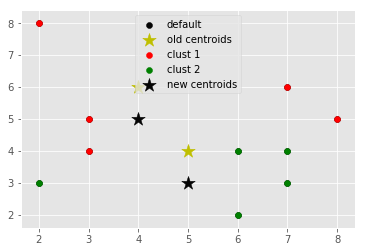

In [6]:
# Number of clusters
k = 2

# X coordinates of random centroids
C_x = np.array([4,5])
# Y coordinates of random centroids
C_y = np.array([6,4])

visualise_football(C_x, C_y,metric='m')

 
Criteria is  Centroids
Distance metric is  Euclidean
Iteration: 1 Current SSE: 57 Previous SSE: 0.1
Iteration: 2 Current SSE: 59 Previous SSE: 57
Iteration: 3 Current SSE: 33 Previous SSE: 59
Number of count: 4


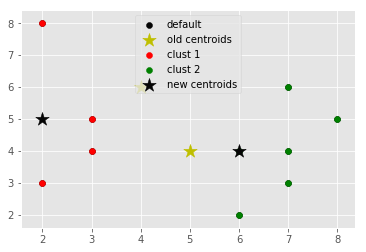

In [7]:
visualise_football(C_x, C_y,metric='e')

 
Criteria is  Centroids
Distance metric is  Manhattan
Iteration: 1 Current SSE: 59 Previous SSE: 0.1
Iteration: 2 Current SSE: 33 Previous SSE: 59
Number of count: 3


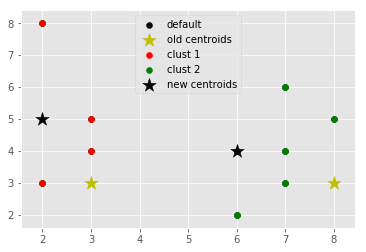

In [8]:
# Number of clusters
k = 2

# X coordinates of random centroids
C_x = np.array([3,8])
# Y coordinates of random centroids
C_y = np.array([3,3])

visualise_football(C_x, C_y,metric='m')

 
Criteria is  Centroids
Distance metric is  Manhattan
Iteration: 1 Current SSE: 116 Previous SSE: 0.1
Iteration: 2 Current SSE: 67 Previous SSE: 116
Number of count: 3


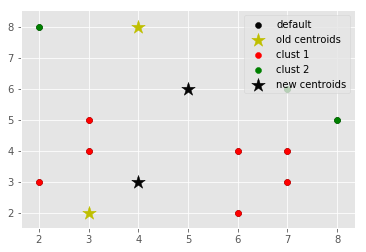

In [9]:
# Number of clusters
k = 2

# X coordinates of random centroids
C_x = np.array([3,4])
# Y coordinates of random centroids
C_y = np.array([2,8])

visualise_football(C_x, C_y,metric='m')

In [11]:
df = pd.read_table(PATH+ "iris.data", sep=",", header=None, names=['sepalLength', 'sepalWidth', 'petalLength', 'petalWidth', 'class'])
# Converting the predicted label "class" to numerical values
df['class'] = pd.Categorical(df['class'])
df['class'] = df['class'].cat.codes
df.head()

,sepalLength,sepalWidth,petalLength,petalWidth,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


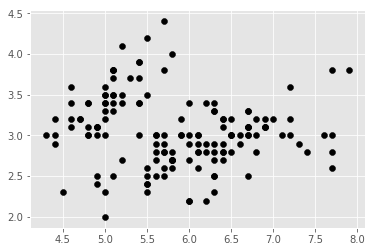

In [12]:
X = df[df.columns[:-1]].values
# X[1].shape
plt.scatter(X[:, 0], X[:, 1], c='black')

 
Criteria is  Centroids
Distance metric is  Euclidean
Iteration: 1 Current SSE: 244.21999999999997 Previous SSE: 0.1
Iteration: 2 Current SSE: 95.8292107332315 Previous SSE: 244.21999999999997
Iteration: 3 Current SSE: 81.73213619027447 Previous SSE: 95.8292107332315
Iteration: 4 Current SSE: 79.8179745332109 Previous SSE: 81.73213619027447
Iteration: 5 Current SSE: 79.43376414532676 Previous SSE: 79.8179745332109
Iteration: 6 Current SSE: 79.01070972222223 Previous SSE: 79.43376414532676
Iteration: 7 Current SSE: 78.94506582597731 Previous SSE: 79.01070972222223
number of count is  8
   
   
The original clusters  are 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
The predicted clusters are 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

number of count is  1
   
   
The original clusters  are 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
The predicted clusters are 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 2. 2. 2. 1. 2. 1. 2. 1. 2. 1. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 2. 1.
 1. 1. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 2. 1. 1. 2. 1. 1. 1. 2.
 1. 1. 1. 1. 1. 1. 2. 1. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 1.
 2. 1. 2. 1. 2. 2. 1. 2. 1. 2. 2. 2. 1. 1. 1. 2. 1. 2. 2. 2. 2. 2. 1. 2.
 2. 2. 1. 2. 2. 2.]
accuracy is 0.75333
 
Criteria is  Max Iteration
Distance metric is  Jacard
Iteration: 1 Current SSE: 247.47999999999996 Previous SSE: 0.1
number of c

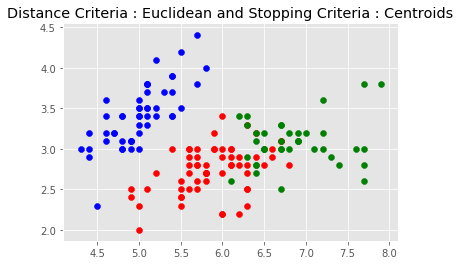

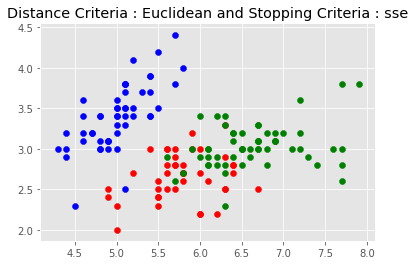

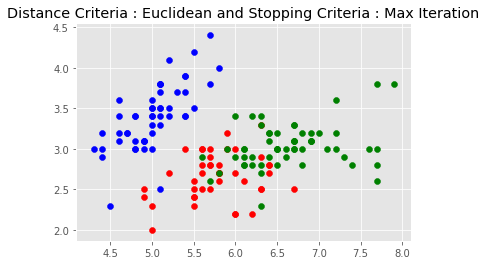

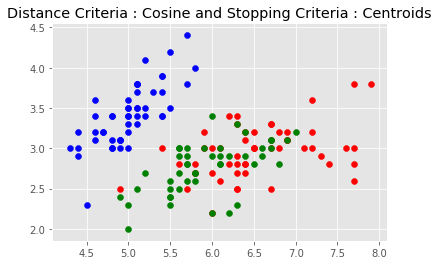

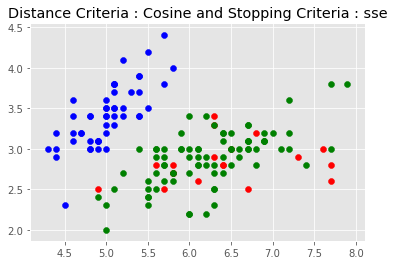

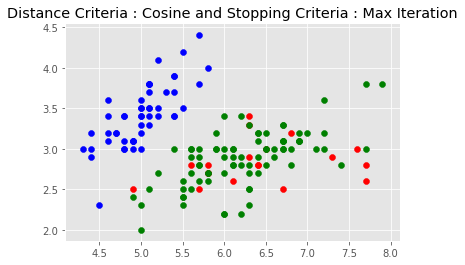

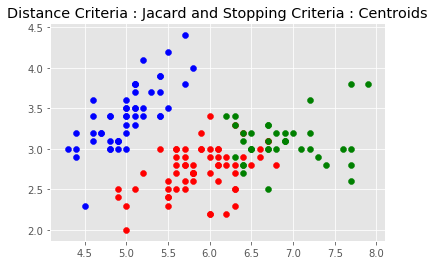

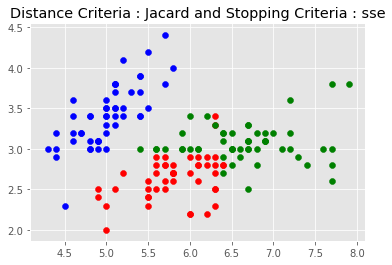

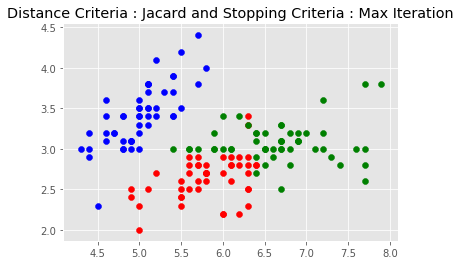

In [13]:
li =['e','c','j']
for jtr in li: 
    for itr in range(3):
        clusters, count = kmeans(X, Centroid=None, k=3,kmeans_metric=jtr,criteria=itr)
        print("number of count is ", str(int(count)))
        visualise_iris(jtr,itr)
        print_accur()

In [14]:
clusters,count = kmeans(X, Centroid=None, k=3,kmeans_metric='j')
print("number of count is ", str(int(count)))
visualise_iris()
print_accur()

 
Criteria is  Centroids
Distance metric is  Jacard
Iteration: 1 Current SSE: 247.47999999999996 Previous SSE: 0.1
Iteration: 2 Current SSE: 90.00413357898154 Previous SSE: 247.47999999999996
Iteration: 3 Current SSE: 80.94872468401527 Previous SSE: 90.00413357898154
Iteration: 4 Current SSE: 80.66126731180464 Previous SSE: 80.94872468401527
Iteration: 5 Current SSE: 80.77045840220387 Previous SSE: 80.66126731180464
Iteration: 6 Current SSE: 80.30974694054882 Previous SSE: 80.77045840220387
Iteration: 7 Current SSE: 79.6915770833333 Previous SSE: 80.30974694054882
Iteration: 8 Current SSE: 79.23624424524454 Previous SSE: 79.6915770833333
Iteration: 9 Current SSE: 79.18674974533107 Previous SSE: 79.23624424524454
number of count is  10


TypeError: visualise_iris() missing 2 required positional arguments: 'kmeans_metric' and 'criteria'

In [15]:
clusters,count = kmeans(X, Centroid=None, k=3,kmeans_metric='c')
print("number of count is ", str(int(count)))
visualise_iris()
print_accur()

 
Criteria is  Centroids
Distance metric is  Cosine
Iteration: 1 Current SSE: 250.34 Previous SSE: 0.1
Iteration: 2 Current SSE: 117.09890070993663 Previous SSE: 250.34
Iteration: 3 Current SSE: 103.07419386085019 Previous SSE: 117.09890070993663
Iteration: 4 Current SSE: 99.52874249566369 Previous SSE: 103.07419386085019
Iteration: 5 Current SSE: 92.4143768244576 Previous SSE: 99.52874249566369
Iteration: 6 Current SSE: 92.07870917874396 Previous SSE: 92.4143768244576
number of count is  7


TypeError: visualise_iris() missing 2 required positional arguments: 'kmeans_metric' and 'criteria'